In [ ]:
import numpy as np
import torch
from torch import nn
import tqdm

In [ ]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


In [ ]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


# Use the following code to create a validation set of 10%
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


#Sample code to visulaize the first sample in first 16 batches

# batch_num = 0
# for train_features, train_labels in train_batches:

#     if batch_num == 16:
#         break    # break here

#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")

    # img = train_features[0].squeeze()
    # label = train_labels[0]
    # plt.imshow(img, cmap="gray")
    # plt.show()
    # print(f"Label: {label}")



#Sample code to plot N^2 images from the dataset
# def plot_images(XX, N, title):
#     fig, ax = plt.subplots(N, N, figsize=(8, 8))

#     for i in range(N):
#       for j in range(N):
#         ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
#         ax[i,j].axis("off")
#     fig.suptitle(title, fontsize=24)

# plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )



100%|██████████| 26.4M/26.4M [00:03<00:00, 8.73MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.18MB/s]

106
12
40


In [ ]:
class ACAIGFCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_prob):
        super(ACAIGFCN, self).__init__()

        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        prev_dim = input_dim

        # Hidden Layers with Dropout
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, h_dim))
            self.dropouts.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            prev_dim = h_dim

        # Output Layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, input):
        for layer, dropout in zip(self.layers, self.dropouts):
            input = torch.nn.functional.relu(layer(input))  # Activation
            input = dropout(input)  # Apply Dropout

        input = self.output_layer(input)
        return input


In [ ]:
def FCN_accuracy(batchSize, test_batch_size, epochs,
                  hidden_dim, learning_rate, optimizer,dropout):

  train_batches = DataLoader(train_split, batch_size=batchSize, shuffle=True)
  val_batches = DataLoader(val_split, batch_size=batchSize, shuffle=True)
  test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

  # Initialize neural network model #[50, 64, 80]
  model = ACAIGFCN(input_dim = 784, output_dim = 10, hidden_dims = hidden_dim, dropout_prob=dropout)

  train_loss_list = np.zeros((epochs,))
  validation_accuracy_list = np.zeros((epochs,))

  # Define loss function  and optimizer
  loss_func = torch.nn.CrossEntropyLoss() # Cross Entropy loss
  optm = optimizer(model.parameters(), lr=learning_rate) # torch.optim.SGD

  # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
  # Track the loss and validation accuracy
  for epoch in tqdm.trange(epochs):
    total_loss = 0

    # ACAIGFCN Training
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()

        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        # Perfrom optimization, back propagation
        optm.zero_grad()
        outputs = model(train_features)
        loss = loss_func(outputs, train_labels)
        loss.backward()
        optm.step()

        total_loss += loss.item()

    # Record loss for the epoch
    train_loss_list[epoch] = total_loss / len(train_batches)


    # ACAIGFCN Validation
    correct = 0
    total = 0
    for val_features, val_labels in val_batches:
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad():
            model.eval()

            # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28*28)

            # Compute validation outputs (targets)
            # and compute accuracy
            validation_outputs = model(val_features)

            correct += (torch.argmax(validation_outputs, dim=1) == val_labels).sum().item()#.type(torch.FloatTensor)
            total += val_labels.size(0)
    validation_accuracy_list[epoch] = (correct / total) * 100
            #validation_accuracy_list[epoch] += correct.mean().item()

    #validation_accuracy_list[epoch] = validation_accuracy_list[epoch]/len(val_batches)

    # Record accuracy for the epoch; print training loss, validation accuracy val_acc * 100:.2f
    print(f"Epoch {epoch+1}: Training Loss = {train_loss_list[epoch]:.4f}, Validation Accuracy: {validation_accuracy_list[epoch] :.2f}%") #)


  #Calculate accuracy on test set
  t_correct = 0
  t_total = 0
  # Telling PyTorch we aren't passing inputs to network for training purpose
  with torch.no_grad():
      for test_features, test_labels in test_batches:
        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

        # Get model predictions
        t_outputs = model(test_features)
        predicted = torch.argmax(t_outputs, dim=1)

        # Count correct predictions
        t_correct += (predicted == test_labels).sum().item()
        t_total += test_labels.size(0)

  # Compute total test accuracy
  test_accuracy = (t_correct / t_total) * 100

  return train_loss_list, validation_accuracy_list, test_accuracy

In [ ]:
train_loss_list, validation_accuracy_list, test_accuracy = FCN_accuracy(450,500,10,[200, 200, 280],0.05,torch.optim.SGD,0)
test_accuracy # =85.2

 10%|█         | 1/10 [00:22<03:24, 22.75s/it]

Epoch 1: Training Loss = 1.3134, Validation Accuracy: 69.50%


 20%|██        | 2/10 [00:38<02:30, 18.85s/it]

Epoch 2: Training Loss = 0.6837, Validation Accuracy: 76.65%


 30%|███       | 3/10 [00:55<02:05, 17.94s/it]

Epoch 3: Training Loss = 0.5564, Validation Accuracy: 80.67%


 40%|████      | 4/10 [01:11<01:42, 17.04s/it]

Epoch 4: Training Loss = 0.4974, Validation Accuracy: 84.23%


 50%|█████     | 5/10 [01:28<01:24, 16.94s/it]

Epoch 5: Training Loss = 0.4631, Validation Accuracy: 85.05%


 60%|██████    | 6/10 [01:44<01:07, 16.78s/it]

Epoch 6: Training Loss = 0.4367, Validation Accuracy: 85.80%


 70%|███████   | 7/10 [02:00<00:49, 16.42s/it]

Epoch 7: Training Loss = 0.4139, Validation Accuracy: 85.18%


 80%|████████  | 8/10 [02:16<00:32, 16.42s/it]

Epoch 8: Training Loss = 0.3991, Validation Accuracy: 86.32%


 90%|█████████ | 9/10 [02:32<00:16, 16.27s/it]

Epoch 9: Training Loss = 0.3876, Validation Accuracy: 87.02%


100%|██████████| 10/10 [02:48<00:00, 16.83s/it]

Epoch 10: Training Loss = 0.3744, Validation Accuracy: 86.55%


85.16

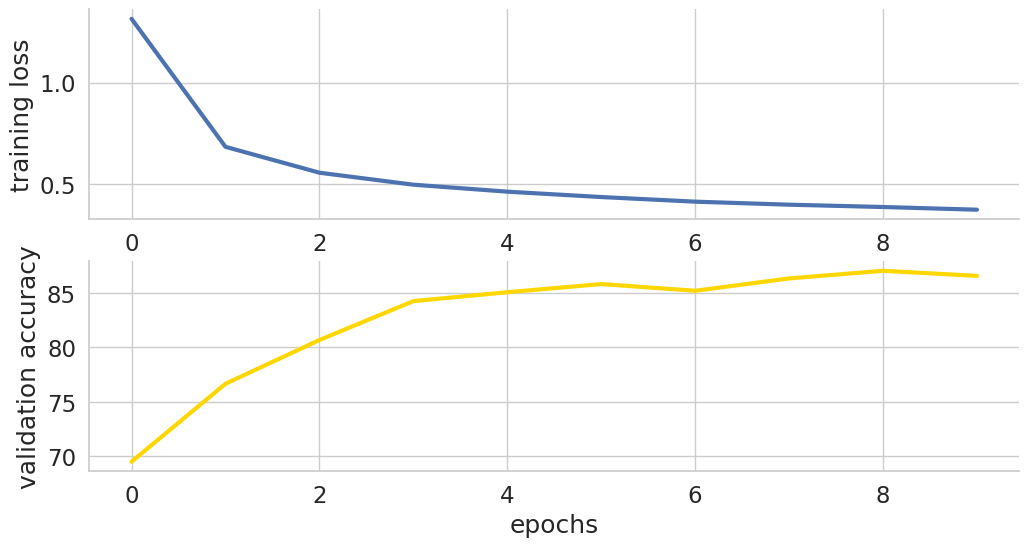

In [ ]:
# Plot training loss and validation accuracy throughout the training epochs
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1.5)
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.xlabel("epochs")
sns.despine()

 10%|█         | 1/10 [00:16<02:24, 16.09s/it]

Epoch 1: Training Loss = 1.1226, Validation Accuracy: 75.67%


 20%|██        | 2/10 [00:31<02:05, 15.65s/it]

Epoch 2: Training Loss = 0.6034, Validation Accuracy: 78.70%


 30%|███       | 3/10 [00:47<01:50, 15.73s/it]

Epoch 3: Training Loss = 0.5062, Validation Accuracy: 83.08%


 40%|████      | 4/10 [01:03<01:35, 15.95s/it]

Epoch 4: Training Loss = 0.4471, Validation Accuracy: 83.97%


 50%|█████     | 5/10 [01:19<01:20, 16.07s/it]

Epoch 5: Training Loss = 0.4189, Validation Accuracy: 83.57%


 60%|██████    | 6/10 [01:35<01:04, 16.07s/it]

Epoch 6: Training Loss = 0.3958, Validation Accuracy: 86.25%


 70%|███████   | 7/10 [01:51<00:47, 15.83s/it]

Epoch 7: Training Loss = 0.3831, Validation Accuracy: 86.02%


 80%|████████  | 8/10 [02:06<00:31, 15.66s/it]

Epoch 8: Training Loss = 0.3703, Validation Accuracy: 83.23%


 90%|█████████ | 9/10 [02:22<00:15, 15.76s/it]

Epoch 9: Training Loss = 0.3579, Validation Accuracy: 86.18%


100%|██████████| 10/10 [02:38<00:00, 15.81s/it]

Epoch 10: Training Loss = 0.3498, Validation Accuracy: 87.45%



 10%|█         | 1/10 [00:15<02:18, 15.36s/it]

Epoch 1: Training Loss = 1.3844, Validation Accuracy: 67.17%


 20%|██        | 2/10 [00:30<02:03, 15.44s/it]

Epoch 2: Training Loss = 0.7138, Validation Accuracy: 77.67%


 30%|███       | 3/10 [00:47<01:51, 15.87s/it]

Epoch 3: Training Loss = 0.5811, Validation Accuracy: 81.87%


 40%|████      | 4/10 [01:02<01:33, 15.65s/it]

Epoch 4: Training Loss = 0.5185, Validation Accuracy: 82.68%


 50%|█████     | 5/10 [01:17<01:17, 15.52s/it]

Epoch 5: Training Loss = 0.4766, Validation Accuracy: 80.85%


 60%|██████    | 6/10 [01:33<01:01, 15.49s/it]

Epoch 6: Training Loss = 0.4493, Validation Accuracy: 84.27%


 70%|███████   | 7/10 [01:49<00:47, 15.76s/it]

Epoch 7: Training Loss = 0.4298, Validation Accuracy: 83.85%


 80%|████████  | 8/10 [02:04<00:31, 15.62s/it]

Epoch 8: Training Loss = 0.4133, Validation Accuracy: 85.37%


 90%|█████████ | 9/10 [02:20<00:15, 15.46s/it]

Epoch 9: Training Loss = 0.4026, Validation Accuracy: 85.67%


100%|██████████| 10/10 [02:35<00:00, 15.52s/it]

Epoch 10: Training Loss = 0.3929, Validation Accuracy: 84.67%



 10%|█         | 1/10 [00:16<02:29, 16.57s/it]

Epoch 1: Training Loss = 2.1875, Validation Accuracy: 37.35%


 20%|██        | 2/10 [00:32<02:07, 15.94s/it]

Epoch 2: Training Loss = 1.6709, Validation Accuracy: 60.58%


 30%|███       | 3/10 [00:47<01:49, 15.60s/it]

Epoch 3: Training Loss = 1.1142, Validation Accuracy: 66.75%


 40%|████      | 4/10 [01:02<01:32, 15.50s/it]

Epoch 4: Training Loss = 0.9142, Validation Accuracy: 69.77%


 50%|█████     | 5/10 [01:18<01:18, 15.79s/it]

Epoch 5: Training Loss = 0.8141, Validation Accuracy: 73.28%


 60%|██████    | 6/10 [01:34<01:02, 15.61s/it]

Epoch 6: Training Loss = 0.7449, Validation Accuracy: 75.72%


 70%|███████   | 7/10 [01:49<00:46, 15.51s/it]

Epoch 7: Training Loss = 0.6924, Validation Accuracy: 77.22%


 80%|████████  | 8/10 [02:04<00:30, 15.43s/it]

Epoch 8: Training Loss = 0.6468, Validation Accuracy: 78.38%


 90%|█████████ | 9/10 [02:20<00:15, 15.50s/it]

Epoch 9: Training Loss = 0.6095, Validation Accuracy: 79.78%


100%|██████████| 10/10 [02:36<00:00, 15.64s/it]

Epoch 10: Training Loss = 0.5796, Validation Accuracy: 81.07%



 10%|█         | 1/10 [00:15<02:17, 15.31s/it]

Epoch 1: Training Loss = 2.2583, Validation Accuracy: 25.82%


 20%|██        | 2/10 [00:30<02:01, 15.23s/it]

Epoch 2: Training Loss = 2.1209, Validation Accuracy: 57.37%


 30%|███       | 3/10 [00:46<01:48, 15.52s/it]

Epoch 3: Training Loss = 1.8381, Validation Accuracy: 61.38%


 40%|████      | 4/10 [01:01<01:32, 15.40s/it]

Epoch 4: Training Loss = 1.4553, Validation Accuracy: 64.83%


 50%|█████     | 5/10 [01:17<01:17, 15.41s/it]

Epoch 5: Training Loss = 1.1711, Validation Accuracy: 65.95%


 60%|██████    | 6/10 [01:32<01:01, 15.35s/it]

Epoch 6: Training Loss = 1.0035, Validation Accuracy: 68.52%


 70%|███████   | 7/10 [01:47<00:45, 15.30s/it]

Epoch 7: Training Loss = 0.9051, Validation Accuracy: 69.42%


 80%|████████  | 8/10 [02:03<00:31, 15.51s/it]

Epoch 8: Training Loss = 0.8422, Validation Accuracy: 70.05%


 90%|█████████ | 9/10 [02:18<00:15, 15.49s/it]

Epoch 9: Training Loss = 0.7981, Validation Accuracy: 71.78%


100%|██████████| 10/10 [02:34<00:00, 15.46s/it]

Epoch 10: Training Loss = 0.7647, Validation Accuracy: 73.20%



 10%|█         | 1/10 [00:16<02:25, 16.11s/it]

Epoch 1: Training Loss = 13.3309, Validation Accuracy: 27.95%


 20%|██        | 2/10 [00:34<02:20, 17.60s/it]

Epoch 2: Training Loss = 1.7480, Validation Accuracy: 29.70%


 30%|███       | 3/10 [00:50<01:56, 16.66s/it]

Epoch 3: Training Loss = 1.9922, Validation Accuracy: 21.47%


 40%|████      | 4/10 [01:05<01:36, 16.13s/it]

Epoch 4: Training Loss = 1.9435, Validation Accuracy: 21.87%


 50%|█████     | 5/10 [01:21<01:20, 16.17s/it]

Epoch 5: Training Loss = 2.0342, Validation Accuracy: 17.30%


 60%|██████    | 6/10 [01:37<01:04, 16.00s/it]

Epoch 6: Training Loss = 1.9706, Validation Accuracy: 19.65%


 70%|███████   | 7/10 [01:53<00:47, 15.85s/it]

Epoch 7: Training Loss = 1.9961, Validation Accuracy: 20.03%


 80%|████████  | 8/10 [02:08<00:31, 15.82s/it]

Epoch 8: Training Loss = 1.9276, Validation Accuracy: 18.62%


 90%|█████████ | 9/10 [02:25<00:16, 16.03s/it]

Epoch 9: Training Loss = 1.9806, Validation Accuracy: 19.10%


100%|██████████| 10/10 [02:40<00:00, 16.09s/it]

Epoch 10: Training Loss = 2.2559, Validation Accuracy: 11.10%



 10%|█         | 1/10 [00:15<02:17, 15.31s/it]

Epoch 1: Training Loss = 2.6230, Validation Accuracy: 71.02%


 20%|██        | 2/10 [00:31<02:04, 15.58s/it]

Epoch 2: Training Loss = 0.7076, Validation Accuracy: 77.80%


 30%|███       | 3/10 [00:46<01:49, 15.58s/it]

Epoch 3: Training Loss = 0.5922, Validation Accuracy: 79.37%


 40%|████      | 4/10 [01:02<01:33, 15.54s/it]

Epoch 4: Training Loss = 0.5851, Validation Accuracy: 81.45%


 50%|█████     | 5/10 [01:17<01:17, 15.49s/it]

Epoch 5: Training Loss = 0.5480, Validation Accuracy: 80.68%


 60%|██████    | 6/10 [01:33<01:02, 15.62s/it]

Epoch 6: Training Loss = 0.5374, Validation Accuracy: 82.17%


 70%|███████   | 7/10 [01:49<00:47, 15.76s/it]

Epoch 7: Training Loss = 0.5522, Validation Accuracy: 83.22%


 80%|████████  | 8/10 [02:05<00:31, 15.69s/it]

Epoch 8: Training Loss = 0.5173, Validation Accuracy: 83.18%


 90%|█████████ | 9/10 [02:20<00:15, 15.62s/it]

Epoch 9: Training Loss = 0.5308, Validation Accuracy: 81.72%


100%|██████████| 10/10 [02:35<00:00, 15.59s/it]

Epoch 10: Training Loss = 0.5265, Validation Accuracy: 78.62%



 10%|█         | 1/10 [00:15<02:18, 15.37s/it]

Epoch 1: Training Loss = 0.6378, Validation Accuracy: 85.28%


 20%|██        | 2/10 [00:30<02:03, 15.38s/it]

Epoch 2: Training Loss = 0.3828, Validation Accuracy: 86.37%


 30%|███       | 3/10 [00:46<01:47, 15.35s/it]

Epoch 3: Training Loss = 0.3444, Validation Accuracy: 87.85%


 40%|████      | 4/10 [01:02<01:33, 15.63s/it]

Epoch 4: Training Loss = 0.3254, Validation Accuracy: 87.27%


 50%|█████     | 5/10 [01:18<01:18, 15.78s/it]

Epoch 5: Training Loss = 0.3112, Validation Accuracy: 87.45%


 60%|██████    | 6/10 [01:33<01:02, 15.66s/it]

Epoch 6: Training Loss = 0.2984, Validation Accuracy: 87.23%


 70%|███████   | 7/10 [01:48<00:46, 15.56s/it]

Epoch 7: Training Loss = 0.2964, Validation Accuracy: 87.88%


 80%|████████  | 8/10 [02:04<00:31, 15.61s/it]

Epoch 8: Training Loss = 0.2772, Validation Accuracy: 88.10%


 90%|█████████ | 9/10 [02:21<00:15, 15.84s/it]

Epoch 9: Training Loss = 0.2715, Validation Accuracy: 88.32%


100%|██████████| 10/10 [02:36<00:00, 15.64s/it]

Epoch 10: Training Loss = 0.2687, Validation Accuracy: 87.32%



 10%|█         | 1/10 [00:15<02:18, 15.42s/it]

Epoch 1: Training Loss = 0.5819, Validation Accuracy: 85.77%


 20%|██        | 2/10 [00:31<02:06, 15.86s/it]

Epoch 2: Training Loss = 0.3648, Validation Accuracy: 86.90%


 30%|███       | 3/10 [00:47<01:49, 15.70s/it]

Epoch 3: Training Loss = 0.3289, Validation Accuracy: 87.62%


 40%|████      | 4/10 [01:02<01:33, 15.53s/it]

Epoch 4: Training Loss = 0.3122, Validation Accuracy: 88.22%


 50%|█████     | 5/10 [01:17<01:17, 15.49s/it]

Epoch 5: Training Loss = 0.2887, Validation Accuracy: 88.48%


 60%|██████    | 6/10 [01:33<01:02, 15.60s/it]

Epoch 6: Training Loss = 0.2801, Validation Accuracy: 88.27%


 70%|███████   | 7/10 [01:49<00:47, 15.70s/it]

Epoch 7: Training Loss = 0.2713, Validation Accuracy: 88.83%


 80%|████████  | 8/10 [02:04<00:31, 15.56s/it]

Epoch 8: Training Loss = 0.2594, Validation Accuracy: 88.90%


 90%|█████████ | 9/10 [02:20<00:15, 15.47s/it]

Epoch 9: Training Loss = 0.2480, Validation Accuracy: 88.78%


100%|██████████| 10/10 [02:35<00:00, 15.53s/it]

Epoch 10: Training Loss = 0.2391, Validation Accuracy: 89.28%



 10%|█         | 1/10 [00:15<02:18, 15.34s/it]

Epoch 1: Training Loss = 90820.0617, Validation Accuracy: 27.15%


 20%|██        | 2/10 [00:30<02:02, 15.36s/it]

Epoch 2: Training Loss = 26.9132, Validation Accuracy: 25.68%


 30%|███       | 3/10 [00:46<01:47, 15.36s/it]

Epoch 3: Training Loss = 10.8363, Validation Accuracy: 25.80%


 40%|████      | 4/10 [01:01<01:33, 15.55s/it]

Epoch 4: Training Loss = 7.3932, Validation Accuracy: 21.97%


 50%|█████     | 5/10 [01:17<01:18, 15.61s/it]

Epoch 5: Training Loss = 2.3447, Validation Accuracy: 22.90%


 60%|██████    | 6/10 [01:32<01:02, 15.51s/it]

Epoch 6: Training Loss = 2.1818, Validation Accuracy: 23.02%


 70%|███████   | 7/10 [01:48<00:46, 15.48s/it]

Epoch 7: Training Loss = 2.1350, Validation Accuracy: 23.07%


 80%|████████  | 8/10 [02:03<00:30, 15.46s/it]

Epoch 8: Training Loss = 2.0426, Validation Accuracy: 24.97%


 90%|█████████ | 9/10 [02:20<00:15, 15.71s/it]

Epoch 9: Training Loss = 2.0760, Validation Accuracy: 22.73%


100%|██████████| 10/10 [02:35<00:00, 15.57s/it]

Epoch 10: Training Loss = 2.0353, Validation Accuracy: 25.57%



 10%|█         | 1/10 [00:15<02:18, 15.35s/it]

Epoch 1: Training Loss = 4893.1038, Validation Accuracy: 52.30%


 20%|██        | 2/10 [00:31<02:06, 15.76s/it]

Epoch 2: Training Loss = 3.4900, Validation Accuracy: 49.88%


 30%|███       | 3/10 [00:46<01:49, 15.68s/it]

Epoch 3: Training Loss = 2.2873, Validation Accuracy: 44.60%


 40%|████      | 4/10 [01:02<01:33, 15.59s/it]

Epoch 4: Training Loss = 1.8547, Validation Accuracy: 46.63%


 50%|█████     | 5/10 [01:17<01:17, 15.57s/it]

Epoch 5: Training Loss = 1.5898, Validation Accuracy: 45.08%


 60%|██████    | 6/10 [01:33<01:02, 15.59s/it]

Epoch 6: Training Loss = 2.1915, Validation Accuracy: 39.47%


 70%|███████   | 7/10 [01:49<00:47, 15.71s/it]

Epoch 7: Training Loss = 2.0585, Validation Accuracy: 37.62%


 80%|████████  | 8/10 [02:04<00:31, 15.59s/it]

Epoch 8: Training Loss = 220.2777, Validation Accuracy: 32.77%


 90%|█████████ | 9/10 [02:20<00:15, 15.55s/it]

Epoch 9: Training Loss = 2.1522, Validation Accuracy: 35.08%


100%|██████████| 10/10 [02:35<00:00, 15.57s/it]

Epoch 10: Training Loss = 1.8397, Validation Accuracy: 34.65%



 10%|█         | 1/10 [00:15<02:19, 15.50s/it]

Epoch 1: Training Loss = 16.2335, Validation Accuracy: 78.68%


 20%|██        | 2/10 [00:31<02:05, 15.65s/it]

Epoch 2: Training Loss = 0.5451, Validation Accuracy: 80.92%


 30%|███       | 3/10 [00:46<01:49, 15.63s/it]

Epoch 3: Training Loss = 0.5038, Validation Accuracy: 80.63%


 40%|████      | 4/10 [01:03<01:35, 15.93s/it]

Epoch 4: Training Loss = 0.5006, Validation Accuracy: 55.58%


 50%|█████     | 5/10 [01:18<01:18, 15.75s/it]

Epoch 5: Training Loss = 0.6617, Validation Accuracy: 83.32%


 60%|██████    | 6/10 [01:33<01:02, 15.57s/it]

Epoch 6: Training Loss = 0.4547, Validation Accuracy: 84.75%


 70%|███████   | 7/10 [01:49<00:46, 15.46s/it]

Epoch 7: Training Loss = 0.4841, Validation Accuracy: 80.42%


 80%|████████  | 8/10 [02:04<00:31, 15.59s/it]

Epoch 8: Training Loss = 0.6217, Validation Accuracy: 59.28%


 90%|█████████ | 9/10 [02:21<00:15, 15.73s/it]

Epoch 9: Training Loss = 0.5032, Validation Accuracy: 80.92%


100%|██████████| 10/10 [02:36<00:00, 15.66s/it]

Epoch 10: Training Loss = 0.4006, Validation Accuracy: 83.50%



 10%|█         | 1/10 [00:15<02:18, 15.34s/it]

Epoch 1: Training Loss = 2.7297, Validation Accuracy: 80.77%


 20%|██        | 2/10 [00:31<02:06, 15.79s/it]

Epoch 2: Training Loss = 0.4986, Validation Accuracy: 83.12%


 30%|███       | 3/10 [00:46<01:49, 15.58s/it]

Epoch 3: Training Loss = 0.4570, Validation Accuracy: 82.63%


 40%|████      | 4/10 [01:02<01:32, 15.47s/it]

Epoch 4: Training Loss = 0.4278, Validation Accuracy: 78.77%


 50%|█████     | 5/10 [01:17<01:17, 15.44s/it]

Epoch 5: Training Loss = 0.3888, Validation Accuracy: 75.67%


 60%|██████    | 6/10 [01:33<01:02, 15.52s/it]

Epoch 6: Training Loss = 0.3809, Validation Accuracy: 84.08%


 70%|███████   | 7/10 [01:48<00:46, 15.61s/it]

Epoch 7: Training Loss = 0.3665, Validation Accuracy: 86.52%


 80%|████████  | 8/10 [02:04<00:31, 15.54s/it]

Epoch 8: Training Loss = 0.3646, Validation Accuracy: 87.08%


 90%|█████████ | 9/10 [02:19<00:15, 15.51s/it]

Epoch 9: Training Loss = 0.3506, Validation Accuracy: 81.32%


100%|██████████| 10/10 [02:35<00:00, 15.52s/it]

Epoch 10: Training Loss = 0.3267, Validation Accuracy: 85.38%


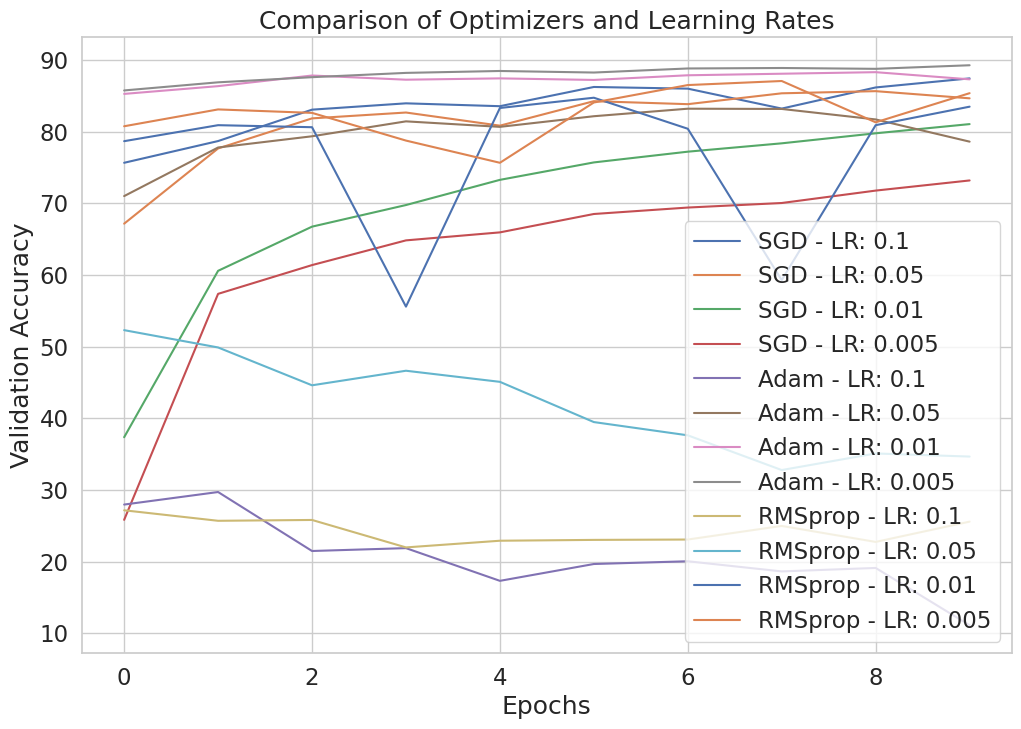

In [ ]:
# Define optimizers to test
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop
}

# Define learning rates to test
learning_rates = [0.1, 0.05, 0.01, 0.005]

# Store results for comparison
results = {}

# Iterate over optimizers and learning rates
for opt_name, opt_func in optimizers.items():
    for lr in learning_rates:
        train_loss_list, val_acc_list, test_acc = FCN_accuracy(
            batchSize=512, test_batch_size=256,
            epochs=10,
            hidden_dim=[100, 200, 180],
            learning_rate=lr, optimizer=opt_func, dropout=0
        )

        # Store results
        results[(opt_name, lr)] = {
            "train_loss": train_loss_list,
            "val_acc": val_acc_list,
            "test_acc": test_acc
        }

# Plot results for comparison
plt.figure(figsize=(12, 8))

for (opt_name, lr), result in results.items():
    plt.plot(result["val_acc"], label=f"{opt_name} - LR: {lr}")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Comparison of Optimizers and Learning Rates")
plt.legend()
plt.show()

In [ ]:
for opt_name, opt_func in optimizers.items():
  for lr in learning_rates:
    print(f'{opt_name} with {lr}:  {results[(opt_name, lr)]["test_acc"]}')

SGD with 0.1:  86.04
SGD with 0.05:  83.88
SGD with 0.01:  79.79
SGD with 0.005:  71.8
Adam with 0.1:  11.15
Adam with 0.05:  77.53
Adam with 0.01:  86.45
Adam with 0.005:  88.12
RMSprop with 0.1:  24.86
RMSprop with 0.05:  33.85
RMSprop with 0.01:  82.07
RMSprop with 0.005:  83.83


 10%|█         | 1/10 [00:16<02:25, 16.20s/it]

Epoch 1: Training Loss = 0.6165, Validation Accuracy: 85.17%


 20%|██        | 2/10 [00:32<02:11, 16.42s/it]

Epoch 2: Training Loss = 0.4042, Validation Accuracy: 85.90%


 30%|███       | 3/10 [00:48<01:52, 16.10s/it]

Epoch 3: Training Loss = 0.3708, Validation Accuracy: 86.20%


 40%|████      | 4/10 [01:04<01:37, 16.24s/it]

Epoch 4: Training Loss = 0.3542, Validation Accuracy: 88.25%


 50%|█████     | 5/10 [01:20<01:20, 16.14s/it]

Epoch 5: Training Loss = 0.3352, Validation Accuracy: 88.62%


 60%|██████    | 6/10 [01:37<01:04, 16.19s/it]

Epoch 6: Training Loss = 0.3174, Validation Accuracy: 88.80%


 70%|███████   | 7/10 [01:52<00:48, 16.05s/it]

Epoch 7: Training Loss = 0.3104, Validation Accuracy: 88.75%


 80%|████████  | 8/10 [02:08<00:31, 15.95s/it]

Epoch 8: Training Loss = 0.3001, Validation Accuracy: 88.23%


 90%|█████████ | 9/10 [02:24<00:15, 15.89s/it]

Epoch 9: Training Loss = 0.2919, Validation Accuracy: 88.78%


100%|██████████| 10/10 [02:40<00:00, 16.09s/it]

Epoch 10: Training Loss = 0.2896, Validation Accuracy: 87.13%


Test Accuracy with dropout_rate 0.1: 85.55%


 10%|█         | 1/10 [00:15<02:20, 15.65s/it]

Epoch 1: Training Loss = 0.6434, Validation Accuracy: 85.73%


 20%|██        | 2/10 [00:31<02:04, 15.61s/it]

Epoch 2: Training Loss = 0.4453, Validation Accuracy: 86.43%


 30%|███       | 3/10 [00:47<01:51, 15.98s/it]

Epoch 3: Training Loss = 0.4105, Validation Accuracy: 87.52%


 40%|████      | 4/10 [01:03<01:34, 15.77s/it]

Epoch 4: Training Loss = 0.3854, Validation Accuracy: 88.05%


 50%|█████     | 5/10 [01:18<01:18, 15.67s/it]

Epoch 5: Training Loss = 0.3670, Validation Accuracy: 88.12%


 60%|██████    | 6/10 [01:34<01:02, 15.69s/it]

Epoch 6: Training Loss = 0.3608, Validation Accuracy: 88.63%


 70%|███████   | 7/10 [01:50<00:47, 15.92s/it]

Epoch 7: Training Loss = 0.3466, Validation Accuracy: 88.32%


 80%|████████  | 8/10 [02:06<00:31, 15.81s/it]

Epoch 8: Training Loss = 0.3418, Validation Accuracy: 88.88%


 90%|█████████ | 9/10 [02:21<00:15, 15.67s/it]

Epoch 9: Training Loss = 0.3390, Validation Accuracy: 88.33%


100%|██████████| 10/10 [02:36<00:00, 15.69s/it]

Epoch 10: Training Loss = 0.3335, Validation Accuracy: 88.75%


Test Accuracy with dropout_rate 0.2: 87.51%


 10%|█         | 1/10 [00:15<02:17, 15.31s/it]

Epoch 1: Training Loss = 0.6839, Validation Accuracy: 84.30%


 20%|██        | 2/10 [00:30<02:02, 15.30s/it]

Epoch 2: Training Loss = 0.4718, Validation Accuracy: 85.65%


 30%|███       | 3/10 [00:45<01:47, 15.30s/it]

Epoch 3: Training Loss = 0.4407, Validation Accuracy: 86.20%


 40%|████      | 4/10 [01:02<01:34, 15.71s/it]

Epoch 4: Training Loss = 0.4295, Validation Accuracy: 86.15%


 50%|█████     | 5/10 [01:17<01:18, 15.71s/it]

Epoch 5: Training Loss = 0.4152, Validation Accuracy: 87.23%


 60%|██████    | 6/10 [01:33<01:02, 15.62s/it]

Epoch 6: Training Loss = 0.4113, Validation Accuracy: 87.32%


 70%|███████   | 7/10 [01:48<00:46, 15.53s/it]

Epoch 7: Training Loss = 0.3978, Validation Accuracy: 87.85%


 80%|████████  | 8/10 [02:04<00:31, 15.74s/it]

Epoch 8: Training Loss = 0.3933, Validation Accuracy: 88.63%


 90%|█████████ | 9/10 [02:20<00:15, 15.63s/it]

Epoch 9: Training Loss = 0.3895, Validation Accuracy: 88.03%


100%|██████████| 10/10 [02:35<00:00, 15.55s/it]

Epoch 10: Training Loss = 0.3830, Validation Accuracy: 88.72%


Test Accuracy with dropout_rate 0.3: 87.18%


 10%|█         | 1/10 [00:15<02:23, 15.96s/it]

Epoch 1: Training Loss = 0.7531, Validation Accuracy: 83.92%


 20%|██        | 2/10 [00:31<02:04, 15.57s/it]

Epoch 2: Training Loss = 0.5331, Validation Accuracy: 85.58%


 30%|███       | 3/10 [00:46<01:49, 15.57s/it]

Epoch 3: Training Loss = 0.4987, Validation Accuracy: 85.67%


 40%|████      | 4/10 [01:02<01:32, 15.49s/it]

Epoch 4: Training Loss = 0.4697, Validation Accuracy: 85.93%


 50%|█████     | 5/10 [01:18<01:18, 15.67s/it]

Epoch 5: Training Loss = 0.4657, Validation Accuracy: 86.13%


 60%|██████    | 6/10 [01:33<01:02, 15.58s/it]

Epoch 6: Training Loss = 0.4685, Validation Accuracy: 87.08%


 70%|███████   | 7/10 [01:48<00:46, 15.49s/it]

Epoch 7: Training Loss = 0.4561, Validation Accuracy: 87.27%


 80%|████████  | 8/10 [02:04<00:30, 15.49s/it]

Epoch 8: Training Loss = 0.4526, Validation Accuracy: 87.72%


 90%|█████████ | 9/10 [02:20<00:15, 15.67s/it]

Epoch 9: Training Loss = 0.4416, Validation Accuracy: 86.60%


100%|██████████| 10/10 [02:35<00:00, 15.58s/it]

Epoch 10: Training Loss = 0.4427, Validation Accuracy: 87.17%


Test Accuracy with dropout_rate 0.4: 85.61%
Best Test Accuracy: 87.51% with dropout_rate 0.2


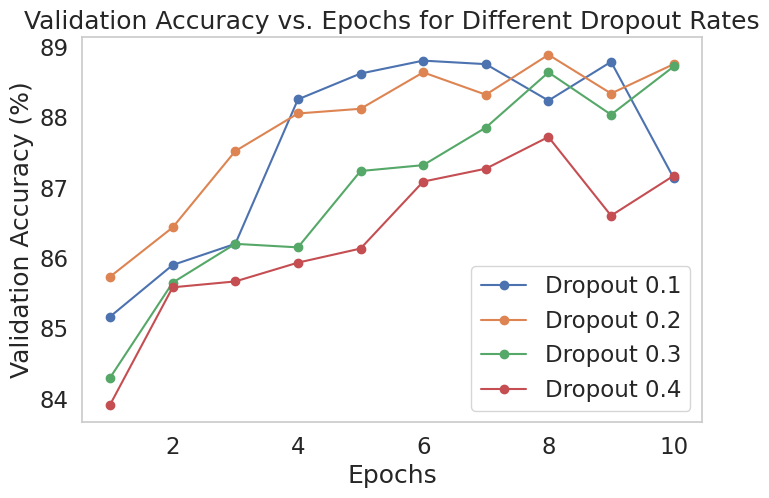

In [ ]:
# Task3(b) adding Dropout
test_acc = 0
best_dr_rt = 0
all_validation_accuracies = []
dropout_rates = [0.1, 0.2, 0.3, 0.4]

for dr_rt in [0.1, 0.2, 0.3, 0.4]:
  train_loss_list, validation_accuracy_list, test_accuracy = FCN_accuracy(
    batchSize=512,
    test_batch_size=256,
    epochs=10,
    hidden_dim=[100, 200, 180],
    learning_rate=0.005,
    optimizer=torch.optim.Adam,
    dropout=dr_rt  # Adjust dropout rate
  )

  all_validation_accuracies.append(validation_accuracy_list)

  if test_accuracy > test_acc:
    test_acc = test_accuracy
    best_dr_rt = dr_rt

  print(f"Test Accuracy with dropout_rate {dr_rt}: {test_accuracy:.2f}%")

print(f"Best Test Accuracy: {test_acc:.2f}% with dropout_rate {best_dr_rt}") # compare to 88.23

# Plot validation accuracy
plt.figure(figsize=(8, 5))
for i, dr_rt in enumerate(dropout_rates):
    plt.plot(range(1, 11), all_validation_accuracies[i], marker='o', label=f"Dropout {dr_rt}")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs. Epochs for Different Dropout Rates")
plt.legend()
plt.grid()
plt.show()

In [37]:
# Task3 (c) Kaiming (He) Uniform
import torch.nn.init as init

class ACAIGFCN1(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_prob):
        super(ACAIGFCN1, self).__init__()

        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        prev_dim = input_dim

        # Hidden Layers with Dropout
        for h_dim in hidden_dims:
            layer = nn.Linear(prev_dim, h_dim)
            self.layers.append(layer)
            self.dropouts.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            prev_dim = h_dim

        # Output Layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

        # Apply Kaiming Uniform Initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)  # Initialize bias to zero

        # Initialize output layer
        nn.init.kaiming_uniform_(self.output_layer.weight, nonlinearity='linear')
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, input):
        for layer, dropout in zip(self.layers, self.dropouts):
            input = torch.nn.functional.relu(layer(input))  # Activation
            input = dropout(input)  # Apply Dropout

        input = self.output_layer(input)
        return input


def FCN_accuracy1(batchSize, test_batch_size, epochs,
                  hidden_dim, learning_rate, optimizer,dropout):

  train_batches = DataLoader(train_split, batch_size=batchSize, shuffle=True)
  val_batches = DataLoader(val_split, batch_size=batchSize, shuffle=True)
  test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

  # Initialize neural network model #[50, 64, 80]
  model = ACAIGFCN1(input_dim = 784, output_dim = 10, hidden_dims = hidden_dim, dropout_prob=dropout)

  train_loss_list = np.zeros((epochs,))
  validation_accuracy_list = np.zeros((epochs,))

  # Define loss function  and optimizer
  loss_func = torch.nn.CrossEntropyLoss() # Cross Entropy loss
  optm = optimizer(model.parameters(), lr=learning_rate) # torch.optim.SGD

  # Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
  # Track the loss and validation accuracy
  for epoch in tqdm.trange(epochs):
    total_loss = 0

    # ACAIGFCN Training
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()

        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        # Perfrom optimization, back propagation
        optm.zero_grad()
        outputs = model(train_features)
        loss = loss_func(outputs, train_labels)
        loss.backward()
        optm.step()

        total_loss += loss.item()

    # Record loss for the epoch
    train_loss_list[epoch] = total_loss / len(train_batches)


    # ACAIGFCN Validation
    correct = 0
    total = 0
    for val_features, val_labels in val_batches:
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad():
            model.eval()

            # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28*28)

            # Compute validation outputs (targets)
            # and compute accuracy
            validation_outputs = model(val_features)

            correct += (torch.argmax(validation_outputs, dim=1) == val_labels).sum().item()#.type(torch.FloatTensor)
            total += val_labels.size(0)
    validation_accuracy_list[epoch] = (correct / total) * 100
            #validation_accuracy_list[epoch] += correct.mean().item()

    #validation_accuracy_list[epoch] = validation_accuracy_list[epoch]/len(val_batches)

    # Record accuracy for the epoch; print training loss, validation accuracy val_acc * 100:.2f
    print(f"Epoch {epoch+1}: Training Loss = {train_loss_list[epoch]:.4f}, Validation Accuracy: {validation_accuracy_list[epoch] :.2f}%") #)


  #Calculate accuracy on test set
  t_correct = 0
  t_total = 0
  # Telling PyTorch we aren't passing inputs to network for training purpose
  with torch.no_grad():
      for test_features, test_labels in test_batches:
        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

        # Get model predictions
        t_outputs = model(test_features)
        predicted = torch.argmax(t_outputs, dim=1)

        # Count correct predictions
        t_correct += (predicted == test_labels).sum().item()
        t_total += test_labels.size(0)

  # Compute total test accuracy
  test_accuracy = (t_correct / t_total) * 100

  return train_loss_list, validation_accuracy_list, test_accuracy

train_loss_list, validation_accuracy_list, test_accuracy = FCN_accuracy1(
    batchSize=512,
    test_batch_size=256,
    epochs=10,
    hidden_dim=[100, 200, 180],
    learning_rate=0.005,
    optimizer=torch.optim.Adam,
    dropout=0.1  # Adjust dropout rate
  )
print(f'Test_accuracy with Kaiming (He) Uniform Initialization: {test_accuracy}')


 10%|█         | 1/10 [00:15<02:22, 15.88s/it]

Epoch 1: Training Loss = 0.7852, Validation Accuracy: 84.48%


 20%|██        | 2/10 [00:31<02:04, 15.61s/it]

Epoch 2: Training Loss = 0.4839, Validation Accuracy: 85.92%


 30%|███       | 3/10 [00:46<01:48, 15.49s/it]

Epoch 3: Training Loss = 0.4434, Validation Accuracy: 86.72%


 40%|████      | 4/10 [01:03<01:35, 15.92s/it]

Epoch 4: Training Loss = 0.4216, Validation Accuracy: 86.53%


 50%|█████     | 5/10 [01:18<01:19, 15.85s/it]

Epoch 5: Training Loss = 0.4087, Validation Accuracy: 87.43%


 60%|██████    | 6/10 [01:34<01:03, 15.78s/it]

Epoch 6: Training Loss = 0.3953, Validation Accuracy: 87.55%


 70%|███████   | 7/10 [01:50<00:47, 15.77s/it]

Epoch 7: Training Loss = 0.3936, Validation Accuracy: 87.58%


 80%|████████  | 8/10 [02:06<00:32, 16.02s/it]

Epoch 8: Training Loss = 0.3732, Validation Accuracy: 88.20%


 90%|█████████ | 9/10 [02:22<00:15, 15.96s/it]

Epoch 9: Training Loss = 0.3699, Validation Accuracy: 88.55%


100%|██████████| 10/10 [02:38<00:00, 15.83s/it]

Epoch 10: Training Loss = 0.3701, Validation Accuracy: 87.88%


Test_accuracy with Kaiming (He) Uniform Initialization: 85.82


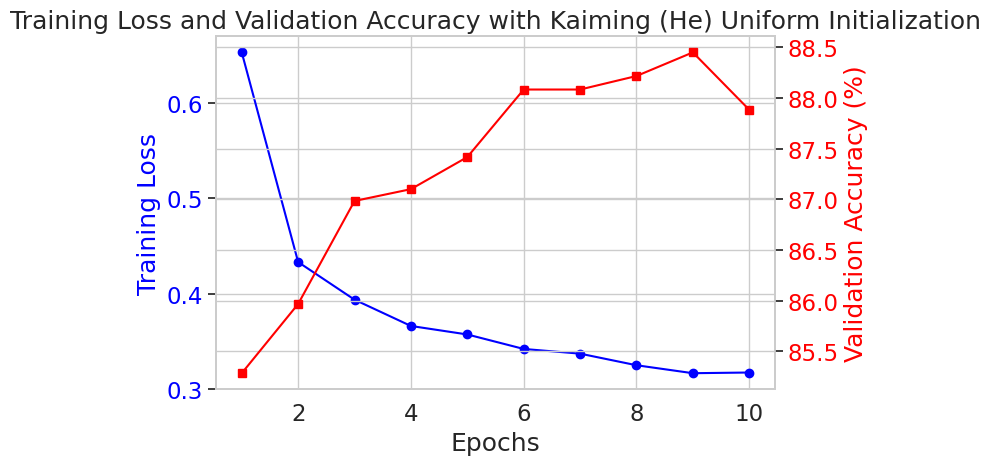

In [36]:
# Create a figure
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Training Loss
ax1.plot(range(1, 11), train_loss_list, marker='o', color='blue', label='Training Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for validation accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, 11), validation_accuracy_list, marker='s', color='red', label='Validation Accuracy')
ax2.set_ylabel("Validation Accuracy (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Titles and legend
plt.title("Training Loss and Validation Accuracy with Kaiming (He) Uniform Initialization")
fig.tight_layout()
plt.show()

In [38]:
# Task 3(d) Batch Normalization

class ACAIGFCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_prob):
        super(ACAIGFCN, self).__init__()

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()  # BatchNorm layers
        self.dropouts = nn.ModuleList()

        prev_dim = input_dim

        # Hidden Layers with BatchNorm and Dropout
        for h_dim in hidden_dims:
            layer = nn.Linear(prev_dim, h_dim)
            self.layers.append(layer)
            self.batch_norms.append(nn.BatchNorm1d(h_dim))  # Apply BatchNorm
            self.dropouts.append(nn.Dropout(p=dropout_prob))  # Apply Dropout
            prev_dim = h_dim

        # Output Layer (no BatchNorm or Dropout)
        self.output_layer = nn.Linear(prev_dim, output_dim)

        # Apply Kaiming Uniform Initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)  # Initialize bias to zero

        nn.init.kaiming_uniform_(self.output_layer.weight, nonlinearity='linear')
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, input):
        for layer, batch_norm, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            input = layer(input)  # Linear layer
            input = batch_norm(input)  # Normalize activations
            input = torch.nn.functional.relu(input)  # Apply ReLU
            input = dropout(input)  # Apply Dropout

        input = self.output_layer(input)  # Final output
        return input



In [45]:
train_loss_list, validation_accuracy_list, test_accuracy = FCN_accuracy(
    batchSize=400,
    test_batch_size=156,
    epochs=10,
    hidden_dim=[100, 200, 180],
    learning_rate=0.005,
    optimizer=torch.optim.Adam,
    dropout=0.1  # Adjust dropout rate
  )
print(f'Test_accuracy with Kaiming (He) Uniform Initialization and Batch normalization(batch size decrease from 512 to 200): {test_accuracy}')

 10%|█         | 1/10 [00:16<02:29, 16.59s/it]

Epoch 1: Training Loss = 0.6299, Validation Accuracy: 85.22%


 20%|██        | 2/10 [00:32<02:08, 16.11s/it]

Epoch 2: Training Loss = 0.4255, Validation Accuracy: 86.90%


 30%|███       | 3/10 [00:48<01:51, 15.94s/it]

Epoch 3: Training Loss = 0.3889, Validation Accuracy: 87.35%


 40%|████      | 4/10 [01:03<01:35, 15.91s/it]

Epoch 4: Training Loss = 0.3666, Validation Accuracy: 87.72%


 50%|█████     | 5/10 [01:20<01:21, 16.22s/it]

Epoch 5: Training Loss = 0.3553, Validation Accuracy: 86.87%


 60%|██████    | 6/10 [01:36<01:04, 16.06s/it]

Epoch 6: Training Loss = 0.3398, Validation Accuracy: 88.37%


 70%|███████   | 7/10 [01:52<00:47, 15.92s/it]

Epoch 7: Training Loss = 0.3335, Validation Accuracy: 88.08%


 80%|████████  | 8/10 [02:07<00:31, 15.91s/it]

Epoch 8: Training Loss = 0.3279, Validation Accuracy: 88.43%


 90%|█████████ | 9/10 [02:24<00:16, 16.20s/it]

Epoch 9: Training Loss = 0.3145, Validation Accuracy: 88.62%


100%|██████████| 10/10 [02:40<00:00, 16.05s/it]

Epoch 10: Training Loss = 0.3150, Validation Accuracy: 88.67%


Test_accuracy with Kaiming (He) Uniform Initialization and Batch normalization(batch size decrease from 512 to 200): 87.48


In [47]:
# Create a figure with two subplots
# fig, ax1 = plt.subplots(figsize=(8, 5))

# # Plot Training Loss
# ax1.plot(range(1, 11), train_loss_list, marker='o', color='blue', label='Training Loss')
# ax1.set_xlabel("Epochs")
# ax1.set_ylabel("Training Loss", color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Create a second y-axis for validation accuracy
# ax2 = ax1.twinx()
# ax2.plot(range(1, 11), validation_accuracy_list, marker='s', color='red', label='Validation Accuracy')
# ax2.set_ylabel("Validation Accuracy (%)", color='red')
# ax2.tick_params(axis='y', labelcolor='red')

# # Title and legend
# plt.title("Training Loss and Validation Accuracy vs. Epochs")
# fig.tight_layout()
# plt.show()
